# Description:
    *Merging raw reads with PEAR
        

# Setting variables




In [1]:
seqDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/'



# Init

In [10]:
import screed
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from mpld3 import enable_notebook
import screed

In [24]:
%reload_ext rpy2.ipython

In [25]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Want to understand how all the pieces fit together? Buy the ggplot2
book: http://ggplot2.org/book/

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/p

## Uncompressing with four files output

In [12]:
uncompFiles = glob(os.path.join(seqDir, 'read?.fq'))

if len(uncompFiles) != 2:
    !cd $seqDir; \
        pigz -k -d -p 24 read?.fq.gz

# Merging

In [13]:
!cd $seqDir; \
    pear -m 600 -j 8 \
    -f read1.fq \
    -r read2.fq \
    -o pear_merged-$(date +%F)

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.10 [May 30, 2016]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: read1.fq
Reverse reads file.................: read2.fq
PHRED..............................: 33
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 600
Minimum assembly length............: 50
p-value............................: 0.010000
Quality score threshold (trimming).: 0
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 1.000000
Minimum overlap....................: 10
Scoring method.....................: Scaled score
Threads............................: 8

Allocating memory..................: 200,000,000 bytes
Computing empirical frequenc

# Make a Screed Database of Merged Reads

A screed database contains sequence information such as sequence name, sequence quality, and the sequence itself in an easily queried format. We will create a screed database using our merged reads for downsream applications.

Create the screed database

In [14]:
pear_merged_file = !echo "pear_merged-"$(date +%F)".assembled.fastq"
pear_merged_file = pear_merged_file[0]

os.chdir(seqDir)
screed.read_fastq_sequences(pear_merged_file)

pear_merged_file += '_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [15]:
pear_merged_file

'pear_merged-2017-04-18.assembled.fastq_screed'

## Checkpoint

In [16]:
pear_merged_file = 'pear_merged-2017-04-18.assembled.fastq_screed'
os.chdir(seqDir)
fqdb = screed.ScreedDB(pear_merged_file)

* Check the lengths of the sequences in your merged sequences file

In [17]:
lengths = []
for read in fqdb.itervalues():
    lengths.append((len(read["sequence"])))

* Plot a histogram to visually check sequence lengths

In [18]:
##Command not working
style.use("ggplot")
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.hist(np.array(lengths), bins=50)
xl = ax.set_xlabel("Sequence Length, nt")
yl = ax.set_ylabel("Count")
fig.set_size_inches((10,6))

NameError: name 'style' is not defined

In [ ]:
print 'Number of reads: {}'.format(len(lengths))

# Quality stats on merged reads

In [19]:
def qualStats(sourceDir, fileName):
    outFile = fileName + '_qualStats'
    !cd $sourceDir; \
        fastx_quality_stats -i $fileName -o $outFile -Q 33
    return outFile
    
qualStatsRes = qualStats(seqDir, 'pear_merged-2017-04-18.assembled.fastq')

## Checkpoint file name

In [20]:
qualStatsRes = seqDir + 'pear_merged-2017-04-18.assembled.fastq' + '_qualStats'

In [21]:
%%R -i seqDir -i qualStatsRes

setwd(seqDir)

# reading in qual-stats files    
tbl.r12 = read.delim(qualStatsRes, sep='\t')
rownames(tbl.r12) = 1:nrow(tbl.r12)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using method = 'loess'

  warnings.warn(x, RRuntimeWarning)


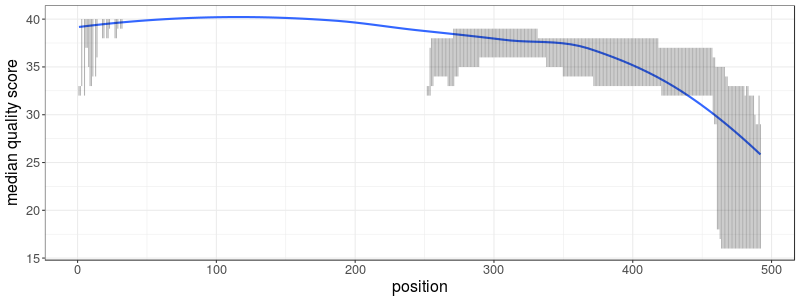

In [26]:
%%R -w 800 -h 300
# smooth curve on median qual values
ggplot(tbl.r12, aes(x=column, y=med, ymin=Q1, ymax=Q3)) +
    geom_smooth(se=FALSE) +
    geom_linerange(alpha=0.3) +
    labs(x='position', y='median quality score') +
    theme_bw() +
    theme( text = element_text(size=16) )

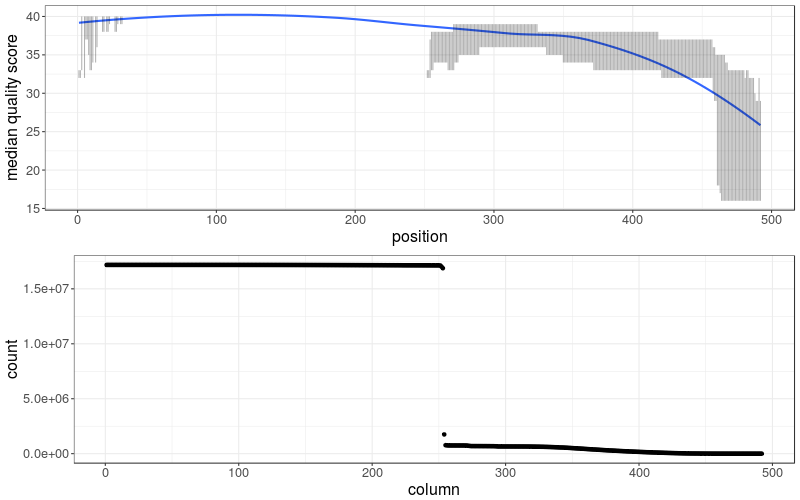

In [27]:
%%R -w 800 -h 500

# smooth curve on median qual values
p1 = ggplot(tbl.r12, aes(x=column, y=med, ymin=Q1, ymax=Q3)) +
    geom_smooth(se=FALSE) +
    geom_linerange(alpha=0.3) +
    labs(x='position', y='median quality score') +
    theme_bw() +
    theme( text = element_text(size=16) )

p2 = ggplot(tbl.r12, aes(x=column, y=count)) +
    geom_point() +
    theme_bw() +
    theme( text = element_text(size=16) )

grid.arrange(p1, p2, ncol=1)

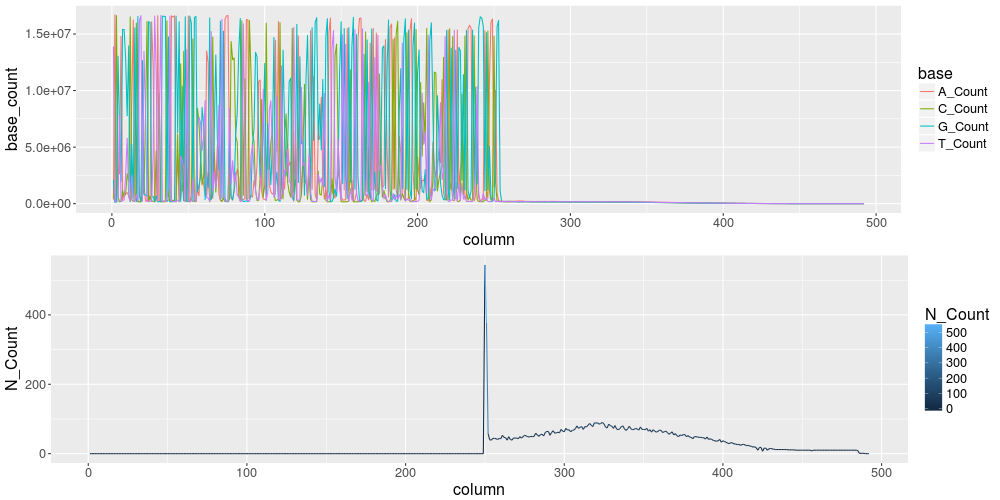

In [28]:
%%R -w 1000 -h 500

tbl.ATGC = tbl.r12 %>%
    select(column, A_Count, G_Count, C_Count, T_Count) %>%
    gather(base, base_count, -column)

tbl.N = tbl.r12 %>%
    select(column, N_Count)


#tbl.ATGC %>% head

p1 = ggplot(tbl.ATGC, aes(x=column, y=base_count, color=base)) +
    geom_line() +
    theme( text = element_text(size=16) )    


p2 = ggplot(tbl.N, aes(x=column, y=N_Count, color=N_Count)) +
    geom_line() +
    theme( text = element_text(size=16) )    

grid.arrange(p1,p2,ncol=1)